In [1]:
import edge_sensor
from edge_sensor.radios import SawtoothSource, NoiseSource, SingleToneSource
from edge_sensor._api.radio import base
from matplotlib import pyplot as plt
import labbench as lb
from scipy import signal
import numpy as np

lb.show_messages('info')

noise1 = NoiseSource()
noise1.open()

noise2 = NoiseSource()
noise2.open()
capture_dir = edge_sensor.RadioCapture(host_resample=False, duration=0.5)
capture_resamp = edge_sensor.RadioCapture(host_resample=True, duration=0.5)
capture_shift = edge_sensor.RadioCapture(
    host_resample=True, lo_shift='left', analysis_bandwidth=10e6, duration=0.5
)

base.design_capture_filter(noise1.base_clock_rate, capture_resamp)

(15625000.0,
 0,
 {'window': 'hamming',
  'nfft': 18750,
  'nfft_out': 18432,
  'frequency_shift': False,
  'passband': (None, None),
  'fs': 15625000.0})

In [2]:
base.get_capture_buffer_sizes(noise1, capture_dir, include_holdoff=True)

(7680000, 7680000)

In [3]:
iq, _ = noise1.acquire(capture_resamp, correction=True)
iq2, _ = noise2.acquire(capture_dir)
# sdr.stream.stop()
print(iq.shape)
# plt.plot(iq.real)
# plt.plot(np.roll(iq2.real))

WARNING 2024-11-14 11:34:49.305 • labbench: cupy is not installed; falling back to cpu with numpy


(7680000,)


[-3145728 -3072000        0  3072000  3145728]
[-3072000        0  3072000]


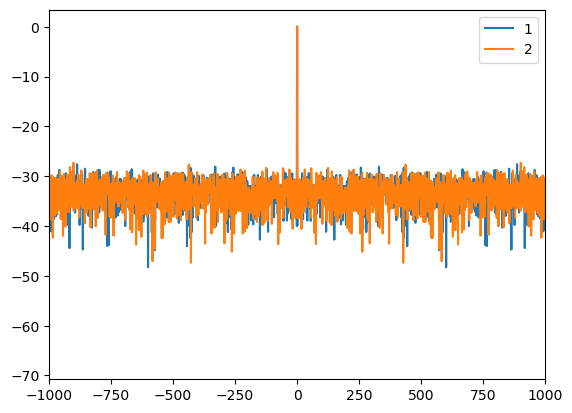

In [4]:
from scipy import signal
import iqwaveform

for name, x in {'1': iq, '2': iq2}.items():
    # R = signal.correlate(iq3, np.roll(iq, 34233))
    R = signal.correlate(x, x, mode='same')
    offs = np.arange(R.size) - R.size // 2
    R /= R.size
    plt.plot(offs, iqwaveform.powtodB(np.abs(R)), label=name)
    plt.xlim([-10e2, 10e2])

    peaks = offs[np.abs(R) > 0.1]
    print(peaks)
    np.diff(peaks)
plt.legend()

[]


array([], dtype=int64)

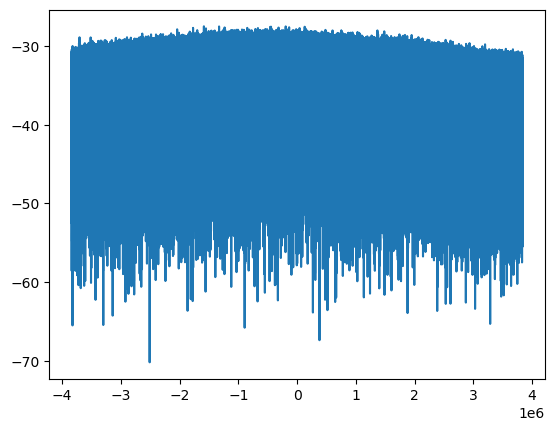

In [ ]:
R = signal.correlate(iq, iq2, mode='same')
offs = np.arange(R.size) - R.size // 2
R /= R.size
plt.plot(offs, iqwaveform.powtodB(np.abs(R)))
# plt.xlim([-10e2, 10e2])

peaks = offs[np.abs(R) > 0.1]
print(peaks)
np.diff(peaks)

### Single-tone source

In [6]:
cw1 = SingleToneSource(resource=0.2)
cw1.open()

cw2 = SingleToneSource(resource=0.2)
cw2.open()

cw3 = SingleToneSource(resource=0.2)
cw3.open()

cw1.arm(capture_resamp)
iq1, _ = cw1.acquire(capture_resamp, correction=True)

cw2.arm(capture_dir)
iq2, _ = cw2.acquire(capture_dir)

cw3.arm(capture_dir)
iq3, _ = cw3.acquire(capture_shift)

# sdr.stream.stop()
# plt.plot(iq.real)
# plt.plot(np.roll(iq2.real))

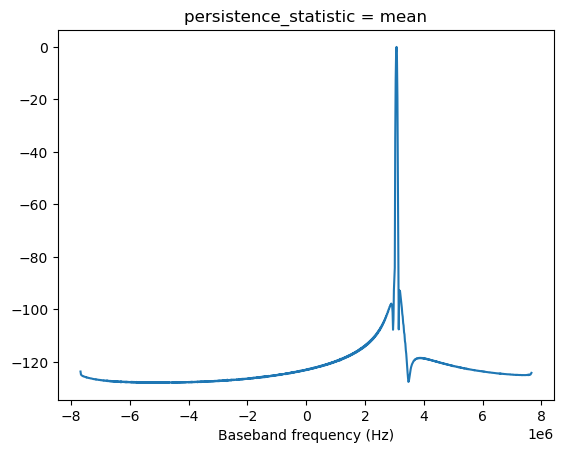

In [7]:
import channel_analysis

result = channel_analysis.measurements.persistence_spectrum(
    iq1,
    capture_dir,
    window=('dpss', 3.5),
    frequency_resolution=15e3,
    persistence_statistics=('mean',),
).to_xarray()
result = result - result.max()
result.plot()

# plt.plot(iq1.real)
# plt.plot(iq2.real)